In [1]:
import torch
from torchvision import transforms 

import numpy as np
from PIL import Image
import requests
import copy
import matplotlib.pyplot as plt

In [2]:
def plot_image(image_batch, title):
    display_image = image_batch[0].permute(1,2,0).numpy()
    
    plt.imshow(display_image)
    plt.title(title)
    plt.show()

In [3]:
def prepare_image(image):
    preprocessing = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    image = preprocessing(image)
    mini_batch = image.unsqueeze(0)
    
    return mini_batch

In [4]:
def postprocess_image(image_tensor):
    
    postprocessing = transforms.Compose([
        transforms.Normalize(mean=[-0.485/.229, -0.456/.224, -0.406/.225], std=[1/0.229, 1/0.224, 1/0.225])
        ])
    display_image = postprocessing(image_tensor)[0]
    display_image = display_image.permute(1,2,0).detach().numpy()
    display_image *= 255
    display_image = display_image.astype(np.uint8)
    display_image = Image.fromarray(display_image, mode='RGB')

    return display_image 

## Prepare the Image of the "Snow Storm" by creating an array with every value being 255

/var/folders/w2/7k8xcq0x0r36wv03zdzfwd640000gn/T/ipykernel_40472/3792520591.py:5: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  snowstorm = Image.fromarray(snowstorm, mode='RGB')


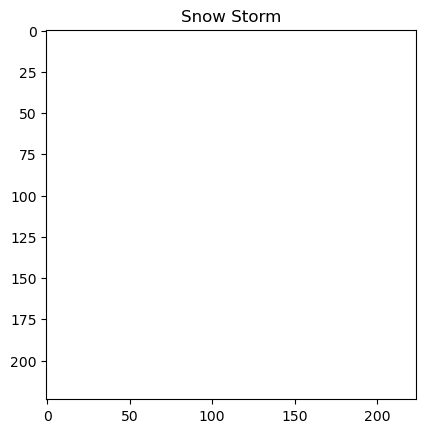

In [5]:
# Create an array of shape (height, width, 3) filled with 255 (white)
snowstorm = np.full((224, 224, 3), 255, dtype=np.uint8)

# Convert to PIL image
snowstorm = Image.fromarray(snowstorm, mode='RGB')

plt.title('Snow Storm')
plt.imshow(snowstorm);

## Prepare the Image of the "Snow Storm" by Resizing, Converting to a Tensor of Floating Point Values, Normalizing the Pixel Values with Respect to the Values in the IMAGENET Dataset, and Creating a Batch of 1 image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.2489083..2.64].


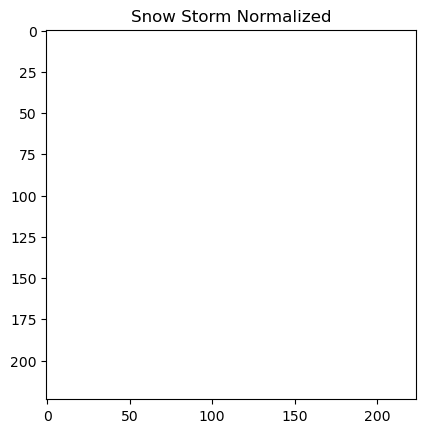

In [6]:
snowstorm = prepare_image(snowstorm)
plot_image(snowstorm, 'Snow Storm Normalized');

## Import the Image Classification Model and Infer upon the Prepared Image of the "Snow Storm"

In [7]:
mobilenetv2 = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights=True).eval()
model_categories_url = 'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt'
model_categories = requests.get(model_categories_url).text.split('\n')

snowstorm_predictions = mobilenetv2(snowstorm)
snowstorm_predictions = torch.nn.functional.softmax(snowstorm_predictions, dim = 1) 

confidences, class_indicies = torch.sort(snowstorm_predictions, descending = True)
predicted_class = model_categories[class_indicies[0,0]]
print(f'{model_categories[class_indicies[0,0]]} with {confidences[0,0]: .4f} confidence')

Using cache found in /Users/asandhir/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/anaconda3/envs/py311_env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


can opener with  0.0088 confidence


## Identify the Target Classes for DeepFool to Itterate Over 

In [8]:
target_classes = ['wood rabbit', 'hare']
target_class_indicies = torch.Tensor([model_categories.index(target_class) for target_class in target_classes]).int()
neighborhood = class_indicies[0, 0:1]
neighborhood = torch.cat((neighborhood, target_class_indicies), dim = 0)

## Specify the Hyperparamters of the DeepFool Algorithm

In [9]:
max_itterations = 100
overshoot = 0.02

## Initalize the Variables Needed to Execute the DeepFool Algorithm

In [10]:
rabbit_in_snowstorm = copy.deepcopy(snowstorm).requires_grad_()
gradient = torch.zeros_like(snowstorm) 
rabbit = torch.zeros_like(snowstorm)

rabbit_in_snowstorm_predictions = mobilenetv2.forward(rabbit_in_snowstorm)
rabbit_in_snowstorm_predictions = torch.nn.functional.softmax(rabbit_in_snowstorm_predictions, dim = 1) 
confidences, class_indicies = torch.sort(rabbit_in_snowstorm_predictions, descending = True)
original_prediction = model_categories[class_indicies[0, 0]]
prediction = original_prediction

itteration = 0

## Execute the DeepFool Algorithm

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.2024565..2.6830373].


hare


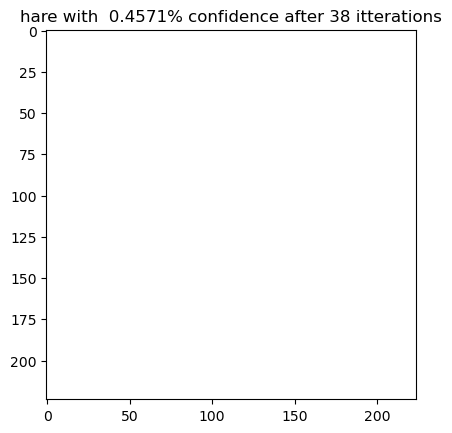

In [11]:
while itteration < max_itterations:
    minimum_perturbation = torch.inf
    rabbit_in_snowstorm_predictions[0, neighborhood[0]].backward(retain_graph = True)
    gradient_datum = rabbit_in_snowstorm.grad.data.detach().clone()

    for neighbor in range(1, len(neighborhood)):
        rabbit_in_snowstorm.grad.zero_()
        rabbit_in_snowstorm_predictions[0, neighborhood[neighbor]].backward(retain_graph = True)
        current_gradient = rabbit_in_snowstorm.grad.data.detach().clone()
        candidate_gradient = current_gradient - gradient_datum
        prediction_delta = (rabbit_in_snowstorm_predictions[0, neighborhood[neighbor]] - rabbit_in_snowstorm_predictions[0, neighborhood[0]]).data

        candidate_perturbation = abs(prediction_delta)/torch.linalg.norm(candidate_gradient.flatten())

        if candidate_perturbation < minimum_perturbation:
            minimum_perturbation = candidate_perturbation
            gradient = candidate_gradient

    incremental_perturbation = (minimum_perturbation + 1e-4) * gradient / torch.linalg.norm(gradient)
    rabbit = rabbit + incremental_perturbation

    rabbit_in_snowstorm = snowstorm + (1 + overshoot) * rabbit
    rabbit_in_snowstorm.requires_grad_()
    rabbit_in_snowstorm_predictions = mobilenetv2.forward(rabbit_in_snowstorm)
    rabbit_in_snowstorm_predictions = torch.nn.functional.softmax(rabbit_in_snowstorm_predictions, dim = 1) 
    confidences, class_indicies = torch.sort(rabbit_in_snowstorm_predictions, descending = True)
    prediction = model_categories[class_indicies[0, 0]]
    if prediction in target_classes:
        print(prediction)
        break

    itteration += 1

plot_image(rabbit_in_snowstorm.detach(), f'{prediction} with {100 * confidences[0,0]: .4f}% confidence after {itteration} itterations')

## Test Whether the Adverserial Perturbations Survive When Converted to a .png File

/var/folders/w2/7k8xcq0x0r36wv03zdzfwd640000gn/T/ipykernel_40472/269466739.py:10: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  display_image = Image.fromarray(display_image, mode='RGB')


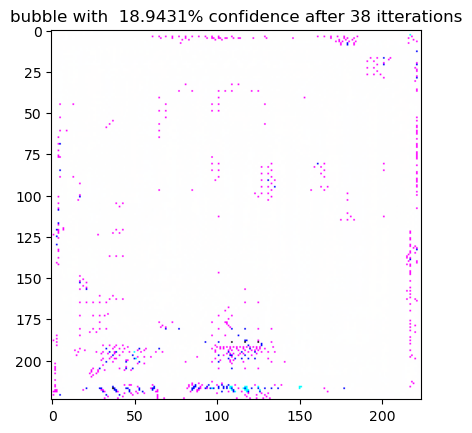

In [12]:
descritized_image = postprocess_image(rabbit_in_snowstorm)

descritized_predictions = mobilenetv2.forward(prepare_image(descritized_image))
descritized_predictions = torch.nn.functional.softmax(descritized_predictions, dim = 1) 
confidences, class_indicies = torch.sort(descritized_predictions, descending = True)

plt.imshow(descritized_image)
plt.title(f'{model_categories[class_indicies[0,0]]} with {100 * confidences[0,0]: .4f}% confidence after {itteration} itterations');
